Starting with importing all packages needed for this notebook.

In [ ]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.pyplot as plt
from rasterio.plot import show
import matplotlib.colors
import numpy as np
import pandas as pd
import rasterio
from osgeo import gdal
import os
import tensorflow
import keras
from keras.models import model_from_json
from keras.optimizers import Adam
from keras.losses import categorical_crossentropy
import tensorflow as tf

np.random.seed(42)

def my_basename(path):
    return os.path.splitext(os.path.split(path)[1])[0]

file_dir=('/Users/maddie/Projects/CPSC_597/')

Reading the main raster as a numpy array

In [8]:
##opening raster as 3d numpy array
inRas=gdal.Open(file_dir+'data/modified_data/stacked_bio_oracle_future/bio_oracle_future_stacked.tif')
myarray=inRas.ReadAsArray()
print(myarray.shape)
print(type(myarray))


(9, 2160, 4320)
<class 'numpy.ndarray'>


Creating a custom color mapping that will be used as the color structure of a heatmap, with darker shades of blue indicating higher likelihood of presence.

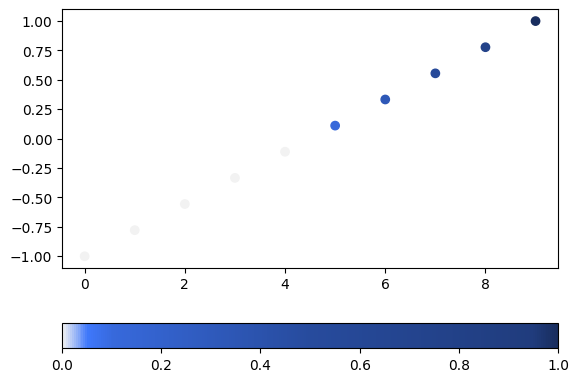

In [9]:
#create colormap for maps
norm = matplotlib.colors.Normalize(0,1)
colors = [[norm(0), "0.95"],
          [norm(0.05),"#3F78FB"],
          [norm(0.1),"#3769DC"],
          [norm(0.3),"#2F5ABC"],
          [norm(0.5),"#274B9D"],
          [norm(0.95),"#203C7D"],
          [norm(1.0),"#182D5E"]]
        
custom_cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", colors)
custom_cmap.set_bad(color="white")

fig, ax=plt.subplots()
x = np.arange(10)
y = np.linspace(-1,1,10)
sc = ax.scatter(x,y, c=y, norm=norm, cmap=custom_cmap)
fig.colorbar(sc, orientation="horizontal")
plt.show()

Reading in the species list and creating prediction heatmaps based of the randomly generated array created at the end of step 6.

All of the finished heatmaps are saved in the results folder, and are separated by species. 

In [10]:
#access file with list of taxa names
taxa=pd.read_csv(file_dir+"results/DNN_performance/DNN_eval.txt",sep="\t")
taxa=taxa["Species"]

In [11]:
%%capture
for species in taxa[:]:

    spec=species
    print("processing", spec)
    spec=spec.replace(" ","_")

    ##########################################################
    #  reconstruct the model and run the prediction globally #
    ##########################################################

    input_X=np.load(file_dir+'data/modified_data/prediction_arrays/future_world_prediction_array.npy')
    df=pd.DataFrame(input_X)

    #create copy of band to later subset values in
    new_band=myarray[1].copy()
    new_band.shape
    
    ### Load DNN model for the species and predict values:
    json_file = open(file_dir+'results/fish_future/{}/{}_future_model.json'.format(spec,spec),'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)

    #load weights into new model
    loaded_model.load_weights(file_dir+'results/fish_future/{}/{}_future_model.h5'.format(spec,spec))

    #compile model
    loaded_model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.001), metrics=['accuracy'])

    #predict values
    new_values = loaded_model.predict(x=input_X,batch_size=500,verbose=0) ###predict output value

    ##take the prob. of presence (new_value.item((0,1))) and put into numpy array
    new_band_values=[]
   
    for i in new_values:
        new_value=i[1]
        new_band_values.append(new_value)
    new_band_values=np.array(new_band_values)

    df=pd.read_csv(file_dir+'data/modified_data/prediction_arrays/future_world_prediction_row_col.csv')
    row=df["row"]
    row=row.values
    col=df["col"]
    col=col.values
    
    #################################
    # subset output into rasterband #
    #################################
    for i in range(0,len(row)):
        new_band[int(row[i]),int(col[i])]=new_band_values[i]

    #new_band[index_minb]=np.nan #exclude lakes, inland seas, coastline
   
    
    src=rasterio.open(file_dir+'data/modified_data/stacked_bio_oracle_future/bio_oracle_future_stacked.tif')
    profile=src.profile
    profile.update(count=1)

    #write to file
    with rasterio.open(file_dir+'results/fish_future/{}/{}_predicted_map_future.tif'.format(spec,spec), 'w', **profile) as dst:
        dst.write(new_band, 1) 
        
    ####################################
    # create additional colormap image #
    ####################################
    
    clipped = rasterio.open(file_dir+'results/fish_future/{}/{}_predicted_map_future.tif'.format(spec,spec))
    
    array = clipped.read(1)
    array_data = clipped.read(1,masked=True)
    array_meta = clipped.profile
    
    #create figure
    my_dpi=96
    fig, ax = plt.subplots(figsize=(4320/my_dpi, 1800/my_dpi))
    im=ax.imshow(array_data,cmap=custom_cmap,interpolation="bilinear",vmin=0,vmax=0.99)#,filternorm=1)
    divider=make_axes_locatable(ax)
    cax=divider.append_axes("right",size="2%",pad=0.1)
    fig.colorbar(im,cax=cax)
    spec=spec.replace("_"," ")
    plt.yticks(fontsize=40)
    ax.set_title('%s prediction map'%spec,fontsize=80)
    
    #save to file
    spec=spec.replace(" ","_")
    plt.savefig(file_dir+'results/fish_future/{}/{}_predicted_map_future_color.png'.format(spec,spec),dpi=my_dpi)
    
    #next species!